In [26]:
import logging
from binance.um_futures import UMFutures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import dateparser
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from scipy import signal
from datetime import datetime

In [27]:
###

akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")
futures_client = Client(key = akey, secret= asec)

###

#DATA PARAMETERS

PREFIX = os.getcwd()
BLOCK = 512
DUMP = '.csv'
DATA_DIR = os.path.join(PREFIX, "datasets")

###

TIMEFRAME = "3d"
PAIR = "ETHUSDT"
# FROM_DATE = "2022-01-14 01:00:00" 
# TO_DATE = "2022-10-05 01:00:00"
FROM_DATE = "2018-10-14" 
TO_DATE = "2022-10-05"
NUM_DATA = 200 #max 100k idk why

###

#PARAMETERS

DATA_WINDOW_LENGTH = BLOCK
ROLLING_WINDOW_LENGTH = 12 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10

###

dir_name = f"{NUM_DATA}_{PAIR}_{TIMEFRAME}_{FROM_DATE.replace(' ', '-').replace(':', '')}_{TO_DATE.replace(' ', '-').replace(':', '')}"

NEW_DATA_DIR = os.path.join(PREFIX, DATA_DIR, dir_name)

if not os.path.exists(NEW_DATA_DIR):
    os.makedirs(NEW_DATA_DIR)
print(NEW_DATA_DIR)    

c:\Users\igor-\.cloned\trailing_orders-1\DEV\datasets\200_ETHUSDT_3d_2018-10-14_2022-10-05


In [28]:
class StaticDatabase:
    def __init__(self, client, pair, timeframe, from_date, to_date, contractType = 'PERPETUAL', limit=1000):
        self.client = client
        self.pair = pair
        self.timeframe = timeframe
        self.contractType = contractType
        self.limit = limit
        self.from_date = pd.Timestamp(from_date)
        self.to_date = pd.Timestamp(to_date)        
        self.from_ts = round(datetime.timestamp(pd.to_datetime(self.from_date, unit="ms")))*1000
        self.to_ts = round(datetime.timestamp(pd.to_datetime(self.to_date, unit="ms")))*1000
        self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.from_ts, limit = self.limit)) 
        # self.last_ts = round(datetime.timestamp(pd.to_datetime(self.data.iloc[-1]['close_time'], unit='ms')))   
        self.last_ts = self.data.iloc[-1]['timestamp']   
        self.length = len(self.data)
        # self.data = pd.DataFrame()
    
    def get_historical_klines(self):

        # print(self.last_ts < self.to_ts)
        
        while (self.length < NUM_DATA) and (self.last_ts < self.to_ts):
            
            if self.length % 1000 == 0: print(self.last_ts < self.to_ts)
            # print(1)
            print(self.data.shape)        
            self.new_data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.last_ts, limit=self.limit))
            self.data = pd.concat([self.data, self.new_data], axis=0).reset_index(drop=True)
            self.length = len(self.data)
            # print(self.data.iloc[-1]['timestamp'] > self.last_ts)
            self.last_ts = self.data.iloc[-1]['timestamp']
            
        # print(self.last_ts < self.to_ts)

        # self.dump_data()                    
                
    def process_klines(self, klines):
        df = pd.DataFrame(klines)
        df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
        df['timestamp'] = df['open_time']
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
        df['open'] = pd.to_numeric(df['open'])
        df['high'] = pd.to_numeric(df['high'])
        df['low'] = pd.to_numeric(df['low'])
        df['close'] = pd.to_numeric(df['close'])
        df['volume'] = pd.to_numeric(df['volume'])
        df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
        df['trades'] = pd.to_numeric(df['trades'])
        df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
        df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
        df['ignore'] = pd.to_numeric(df['ignore'])
        df.drop(['ignore'], axis=1, inplace=True)
        # df.drop(['close_time'], axis=1, inplace=True)
        return df
    def make_features_and_labels(self):
        df = self.data
        features = self.data[['open_time', 'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume']]
        self.features = features
        


        ###

        #LABEL
        
        mean_std = self.closes_std.mean()

        # peak_indexes, _ = signal.find_peaks(df.close.values, threshold=mean_std/2)
        # peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
        peak_indexes, _ = signal.find_peaks(df.close.values, prominence=2*mean_std)
        peak_regions = []
        
        for peak_index in peak_indexes:

            peak_regions.append(peak_index)

            for j in range(min(max(peak_index, len(df.close.values) - max(peak_indexes))-1, 5)):

                if peak_index+j >= len(df.close):
                    break

                if np.abs(df.close.values[peak_index-j] - df.close.values[peak_index]) < mean_std/4:

                    peak_regions.append(peak_index-j)
                elif np.abs(df.close.values[peak_index+j] - df.close.values[peak_index]) < mean_std/4:
                    peak_regions.append(peak_index+j)        



        # valley_indexes, _ = signal.find_peaks(-1*df.close.values, threshold=mean_std/2)
        # valley_indexes, _ = signal.find_peaks(-1*df.close.values, prominence=1.5*mean_std)
        valley_indexes, _ = signal.find_peaks((-1)*df.close.values, prominence=2*mean_std)
        valley_regions = []
        
        for valley_index in valley_indexes:
            # for j in range(min(valley_index, len(df.close.values) - max(valley_indexes), 5)):
            for j in range(min(max(valley_index, len(df.close.values) - max(peak_indexes))-1, 5)):
                if np.abs(df.close.values[valley_index-j] - df.close.values[valley_index]) < mean_std/4:
                    valley_regions.append(valley_index-j)
                elif np.abs(df.close.values[valley_index+j] - df.close.values[valley_index]) < mean_std/4:
                    valley_regions.append(valley_index+j)    
   
        labels = pd.DataFrame()
        self.labels = labels
        self.data_alchemy()    


    def data_alchemy(self):
        
        #FEATURE ENGINEERING
        df = self.data
        df["closes_ema"] = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
        df["closes_std"] = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()
        df["closes_z"] = (df.close - df.closes_ema) / df.closes_std
        df["closes_z"] = df.closes_z.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
        


    def dump_data(self, dir_name=None):
        if DUMP == '.json':
            self.data.to_json(os.path.join(NEW_DATA_DIR, f"{PAIR}_{TIMEFRAME}{DUMP}"), index=False)
        elif DUMP == '.csv':
            self.data.to_csv(os.path.join(NEW_DATA_DIR, f"{PAIR}_{TIMEFRAME}{DUMP}"), index=False) 
            



In [29]:
sdb = StaticDatabase(futures_client, PAIR, TIMEFRAME, FROM_DATE, TO_DATE)

In [30]:
sdb.data

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,timestamp
0,2019-11-27,146.00,157.40,125.03,154.41,4.006420e+05,2019-11-29 23:59:59.999,6.102741e+07,64529,1.493024e+05,2.280285e+07,1574812800000
1,2019-11-30,154.40,155.15,145.50,148.59,1.160617e+06,2019-12-02 23:59:59.999,1.741101e+08,133426,4.240349e+05,6.363350e+07,1575072000000
2,2019-12-03,148.59,152.22,142.96,148.04,1.621515e+06,2019-12-05 23:59:59.999,2.385031e+08,126763,7.821871e+05,1.150296e+08,1575331200000
3,2019-12-06,148.08,156.25,145.66,150.41,8.344414e+05,2019-12-08 23:59:59.999,1.235730e+08,84007,4.218255e+05,6.249326e+07,1575590400000
4,2019-12-09,150.41,151.15,142.02,143.35,7.579560e+05,2019-12-11 23:59:59.999,1.112699e+08,77445,3.585358e+05,5.265355e+07,1575849600000
...,...,...,...,...,...,...,...,...,...,...,...,...
349,2022-10-06,1351.60,1383.29,1302.00,1314.74,1.440381e+07,2022-10-08 23:59:59.999,1.943072e+10,8061324,7.130207e+06,9.622846e+09,1665014400000
350,2022-10-09,1314.75,1337.93,1265.00,1279.68,1.278600e+07,2022-10-11 23:59:59.999,1.661448e+10,7037719,6.308722e+06,8.198932e+09,1665273600000
351,2022-10-12,1279.67,1343.36,1176.00,1295.35,2.210043e+07,2022-10-14 23:59:59.999,2.198265e+10,11367477,1.106874e+07,1.099498e+10,1665532800000
352,2022-10-15,1295.34,1338.16,1262.12,1330.62,1.148738e+07,2022-10-17 23:59:59.999,1.496143e+10,6089134,5.780609e+06,7.532021e+09,1665792000000


In [31]:
sdb.get_historical_klines()

In [32]:
sdb.data_alchemy()

In [33]:
sdb.data

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,timestamp,closes_ema,closes_std,closes_z
0,2019-11-27,146.00,157.40,125.03,154.41,4.006420e+05,2019-11-29 23:59:59.999,6.102741e+07,64529,1.493024e+05,2.280285e+07,1574812800000,NaN,NaN,NaN
1,2019-11-30,154.40,155.15,145.50,148.59,1.160617e+06,2019-12-02 23:59:59.999,1.741101e+08,133426,4.240349e+05,6.363350e+07,1575072000000,NaN,NaN,NaN
2,2019-12-03,148.59,152.22,142.96,148.04,1.621515e+06,2019-12-05 23:59:59.999,2.385031e+08,126763,7.821871e+05,1.150296e+08,1575331200000,NaN,NaN,NaN
3,2019-12-06,148.08,156.25,145.66,150.41,8.344414e+05,2019-12-08 23:59:59.999,1.235730e+08,84007,4.218255e+05,6.249326e+07,1575590400000,NaN,NaN,NaN
4,2019-12-09,150.41,151.15,142.02,143.35,7.579560e+05,2019-12-11 23:59:59.999,1.112699e+08,77445,3.585358e+05,5.265355e+07,1575849600000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,2022-10-06,1351.60,1383.29,1302.00,1314.74,1.440381e+07,2022-10-08 23:59:59.999,1.943072e+10,8061324,7.130207e+06,9.622846e+09,1665014400000,1316.763231,40.180660,-0.042599
350,2022-10-09,1314.75,1337.93,1265.00,1279.68,1.278600e+07,2022-10-11 23:59:59.999,1.661448e+10,7037719,6.308722e+06,8.198932e+09,1665273600000,1281.997702,38.956360,-0.058439
351,2022-10-12,1279.67,1343.36,1176.00,1295.35,2.210043e+07,2022-10-14 23:59:59.999,2.198265e+10,11367477,1.106874e+07,1.099498e+10,1665532800000,1294.515481,27.797746,0.024492
352,2022-10-15,1295.34,1338.16,1262.12,1330.62,1.148738e+07,2022-10-17 23:59:59.999,1.496143e+10,6089134,5.780609e+06,7.532021e+09,1665792000000,1328.363468,27.852400,0.077485


In [34]:
df = sdb.data
closes_mean = df.closes_ema

closes_std = df.closes_std

mean_std = closes_std.mean()
closes_mean.mean(), mean_std


(1710.7703968999376, 125.44626580244044)

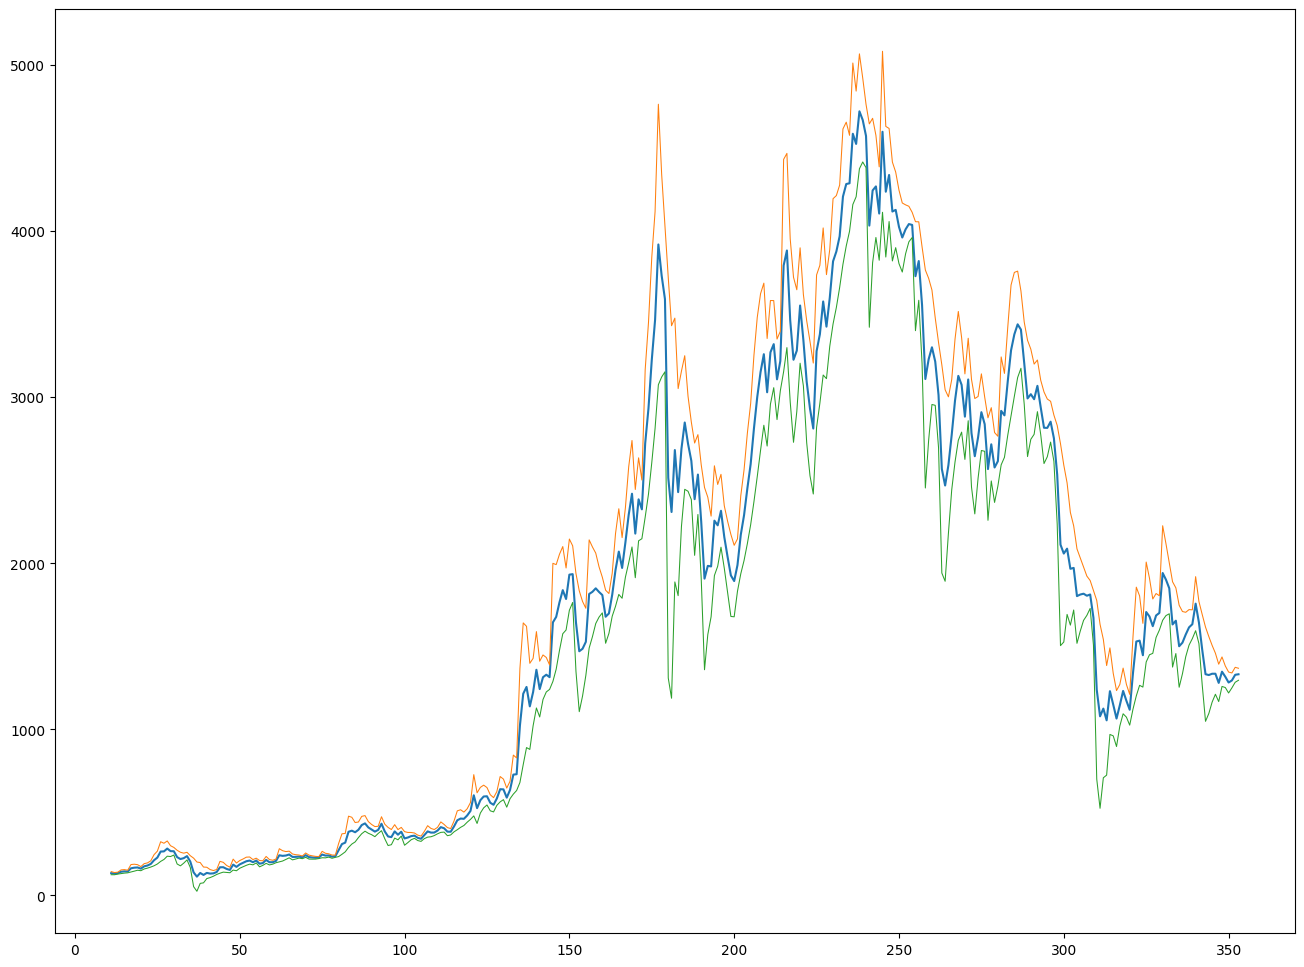

In [35]:
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.closes_ema)
ax.plot(df.closes_ema + 1.618*df.closes_std, linewidth=0.75)
ax.plot(df.closes_ema - 1.618*df.closes_std, linewidth=0.75)
# ax.plot(closes_mean + closes_std, linewidth=0.5)
# ax.plot(closes_mean - closes_std, linewidth=0.5)

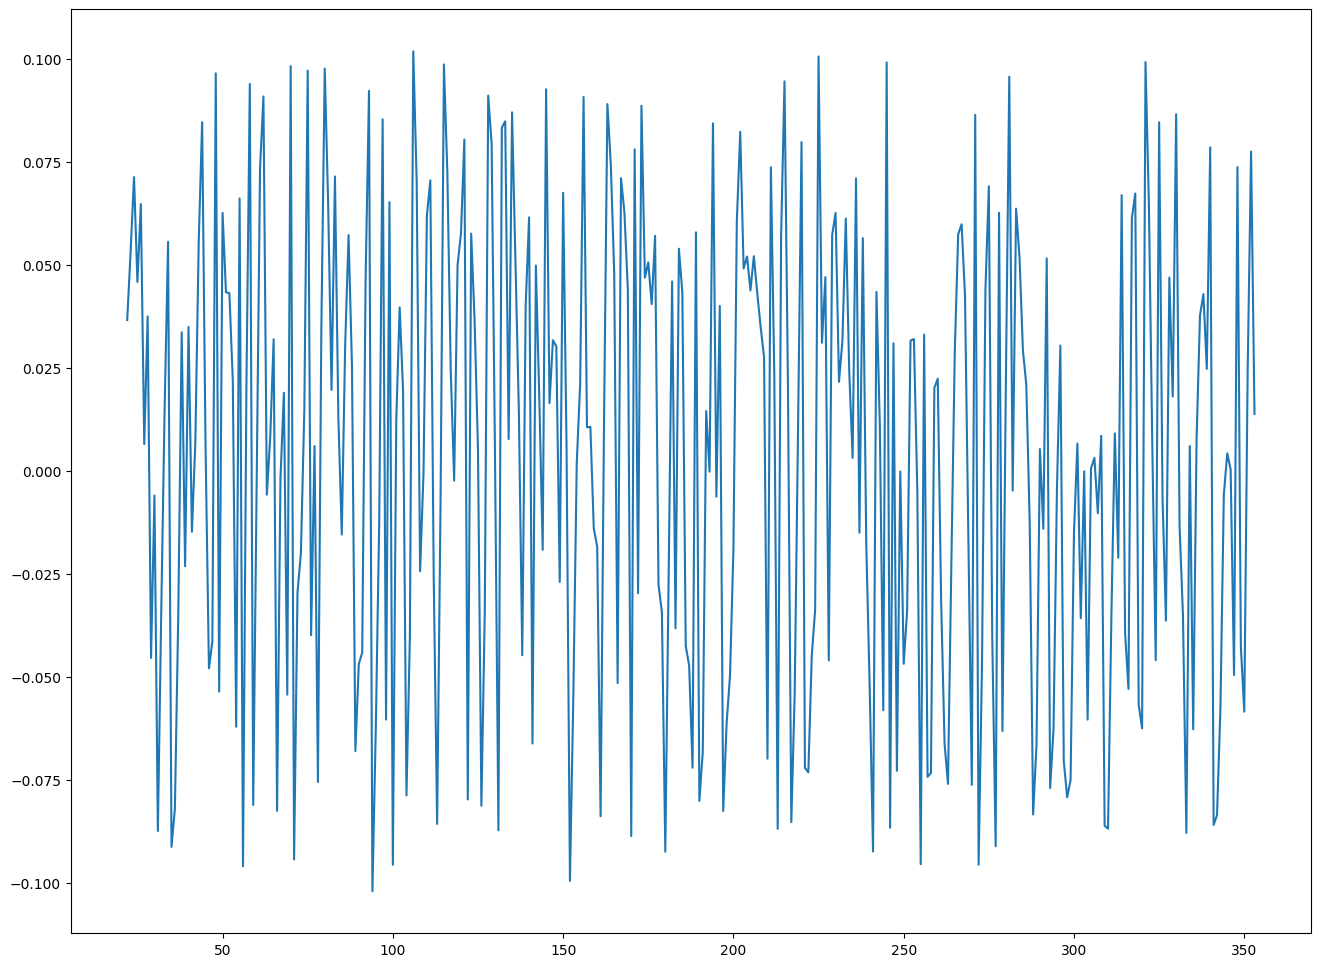

In [36]:
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.closes_z)


In [37]:

# peak_indexes, _ = signal.find_peaks(df.close.values, threshold=mean_std/2)
# peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
peak_indexes, _ = signal.find_peaks(df.close.values, prominence=2*mean_std)
print(peak_indexes)

# valley_indexes, _ = signal.find_peaks(-1*df.close.values, threshold=mean_std/2)
# valley_indexes, _ = signal.find_peaks(-1*df.close.values, prominence=1.5*mean_std)
valley_indexes, _ = signal.find_peaks((-1)*df.close.values, prominence=2*mean_std)
print(valley_indexes)

[150 169 177 182 185 196 209 216 220 238 245 268 271 275 286 330 340]
[153 170 181 183 191 200 210 218 224 241 264 270 273 277 313 335]


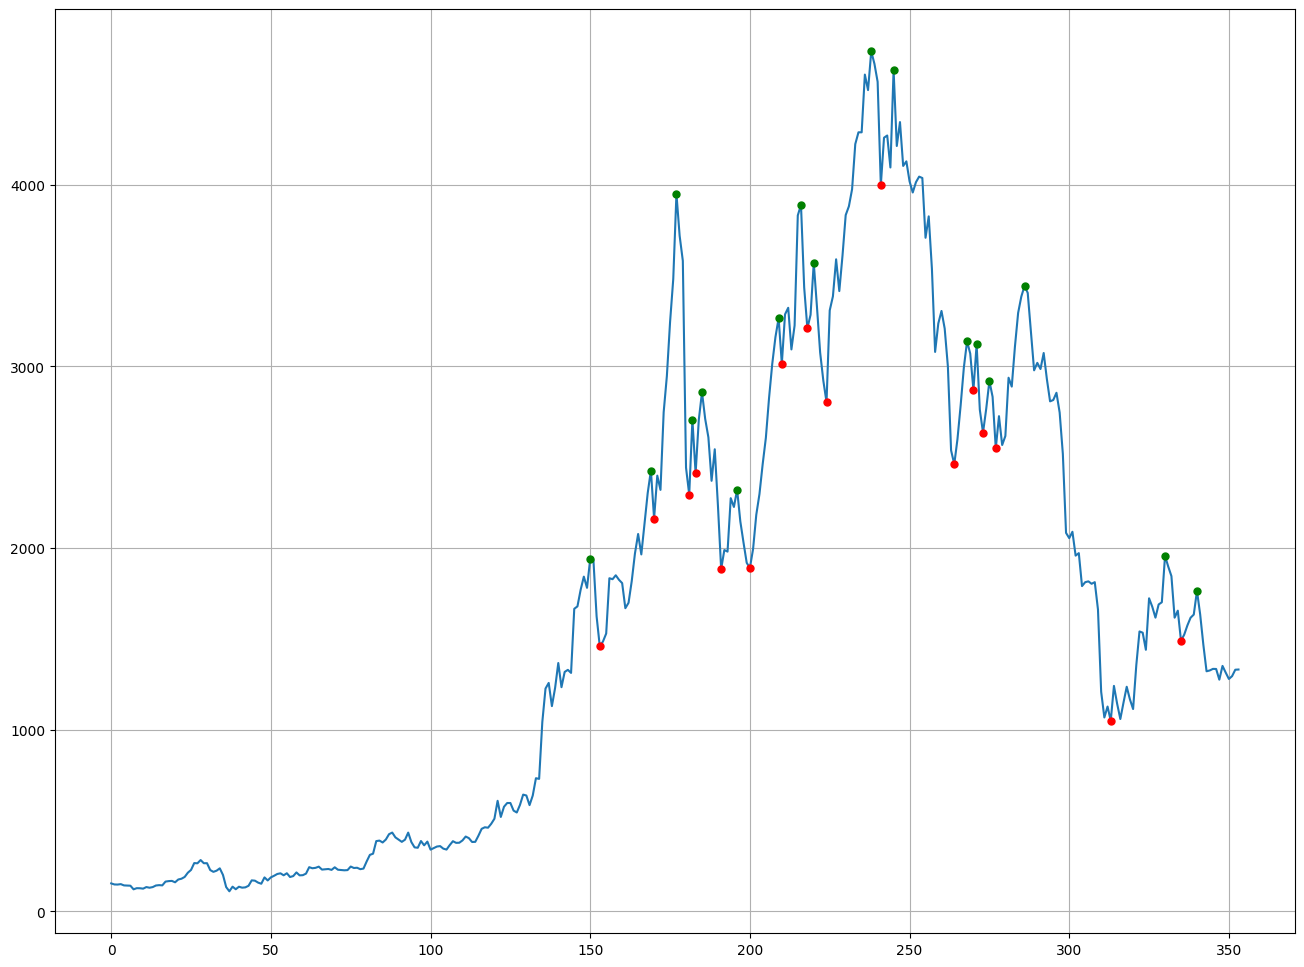

In [38]:
# plot peaks
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

peak_x = peak_indexes
peak_y = df.close.values[peak_indexes]
ax.plot(peak_x, peak_y, marker='o', markersize=5, linestyle="None", color='green', label="Peaks")
 
# plot valleys
valley_x = valley_indexes
valley_y = df.close.values[valley_indexes]
ax.plot(valley_x, valley_y, marker='o', markersize=5, linestyle="None", color='red', label="Valleys")

ax.grid()

In [39]:
peak_regions = []
for peak_index in peak_indexes:

    peak_regions.append(peak_index)

    for j in range(min(max(peak_index, len(df.close.values) - max(peak_indexes))-1, 5)):

        if peak_index+j >= len(df.close):
            break

        print(peak_index-j, peak_index+j)
        if np.abs(df.close.values[peak_index-j] - df.close.values[peak_index]) < mean_std/4:

            peak_regions.append(peak_index-j)
        elif np.abs(df.close.values[peak_index+j] - df.close.values[peak_index]) < mean_std/4:
            peak_regions.append(peak_index+j)        
print(len(peak_regions) - len(peak_indexes))
valley_regions = []
for valley_index in valley_indexes:
    # for j in range(min(valley_index, len(df.close.values) - max(valley_indexes), 5)):
    for j in range(min(max(valley_index, len(df.close.values) - max(peak_indexes))-1, 5)):
        if np.abs(df.close.values[valley_index-j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index-j)
        elif np.abs(df.close.values[valley_index+j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index+j)    
print(len(valley_regions) - len(valley_indexes))

150 150
149 151
148 152
147 153
146 154
169 169
168 170
167 171
166 172
165 173
177 177
176 178
175 179
174 180
173 181
182 182
181 183
180 184
179 185
178 186
185 185
184 186
183 187
182 188
181 189
196 196
195 197
194 198
193 199
192 200
209 209
208 210
207 211
206 212
205 213
216 216
215 217
214 218
213 219
212 220
220 220
219 221
218 222
217 223
216 224
238 238
237 239
236 240
235 241
234 242
245 245
244 246
243 247
242 248
241 249
268 268
267 269
266 270
265 271
264 272
271 271
270 272
269 273
268 274
267 275
275 275
274 276
273 277
272 278
271 279
286 286
285 287
284 288
283 289
282 290
330 330
329 331
328 332
327 333
326 334
340 340
339 341
338 342
337 343
336 344
24
9


In [40]:
len(peak_regions) - len(peak_indexes)

24

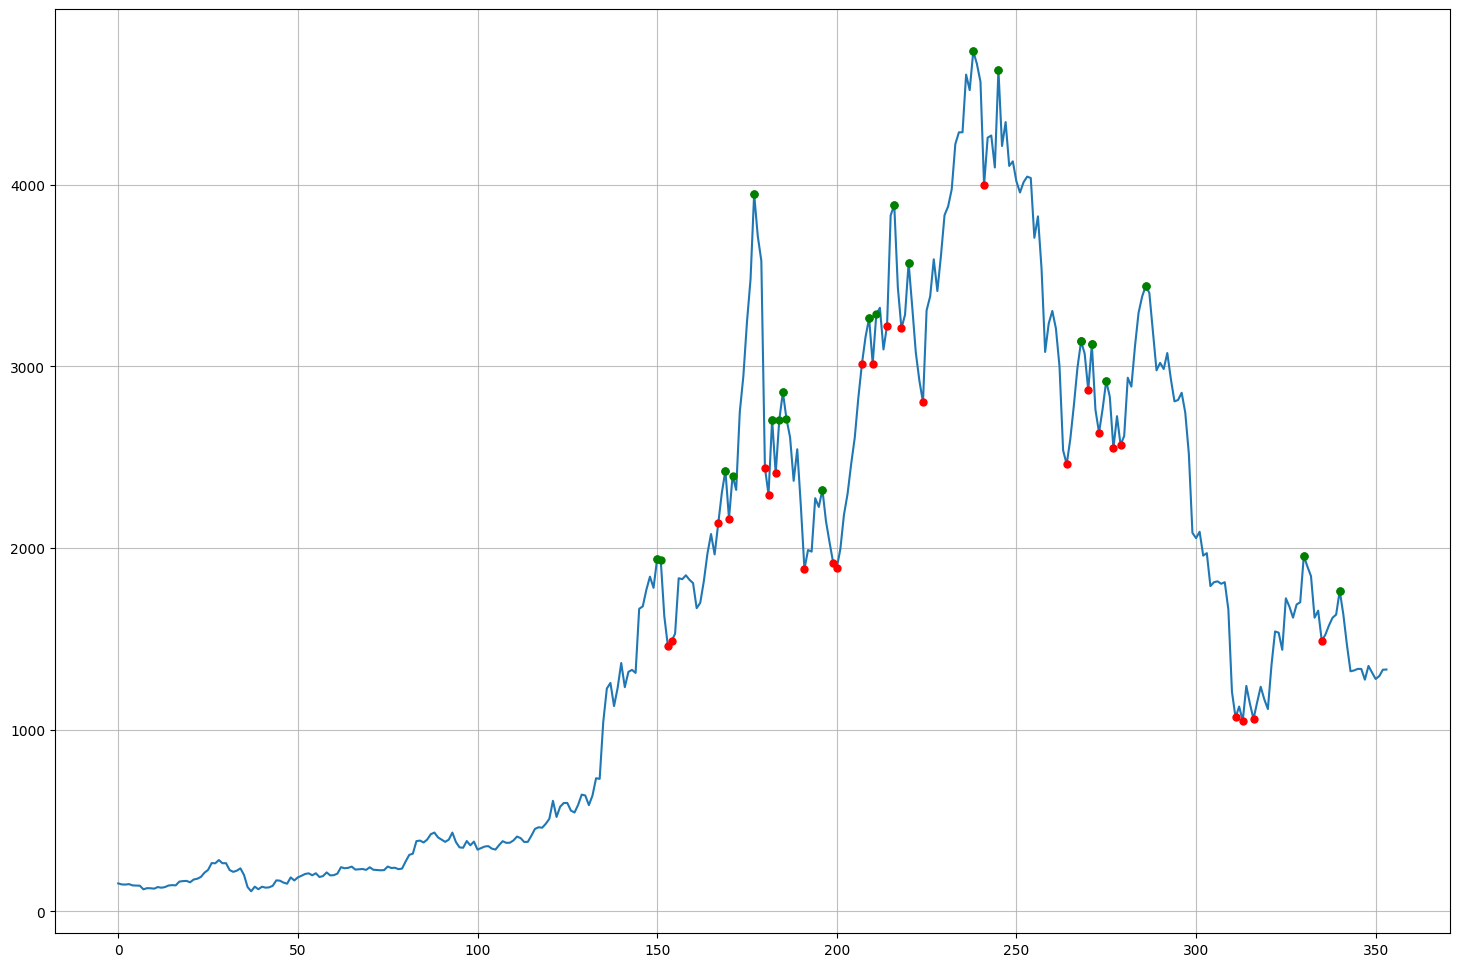

In [49]:
df = sdb.data
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(df.close)

peak_x = peak_regions
peak_y = df.close.values[peak_regions]
ax.plot(peak_x, peak_y, marker='o', markersize=5, linestyle="None", color='green', label="Peaks")

valley_x = valley_regions
valley_y = df.close.values[valley_regions]
ax.plot(valley_x, valley_y, marker='o', markersize=5, linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")


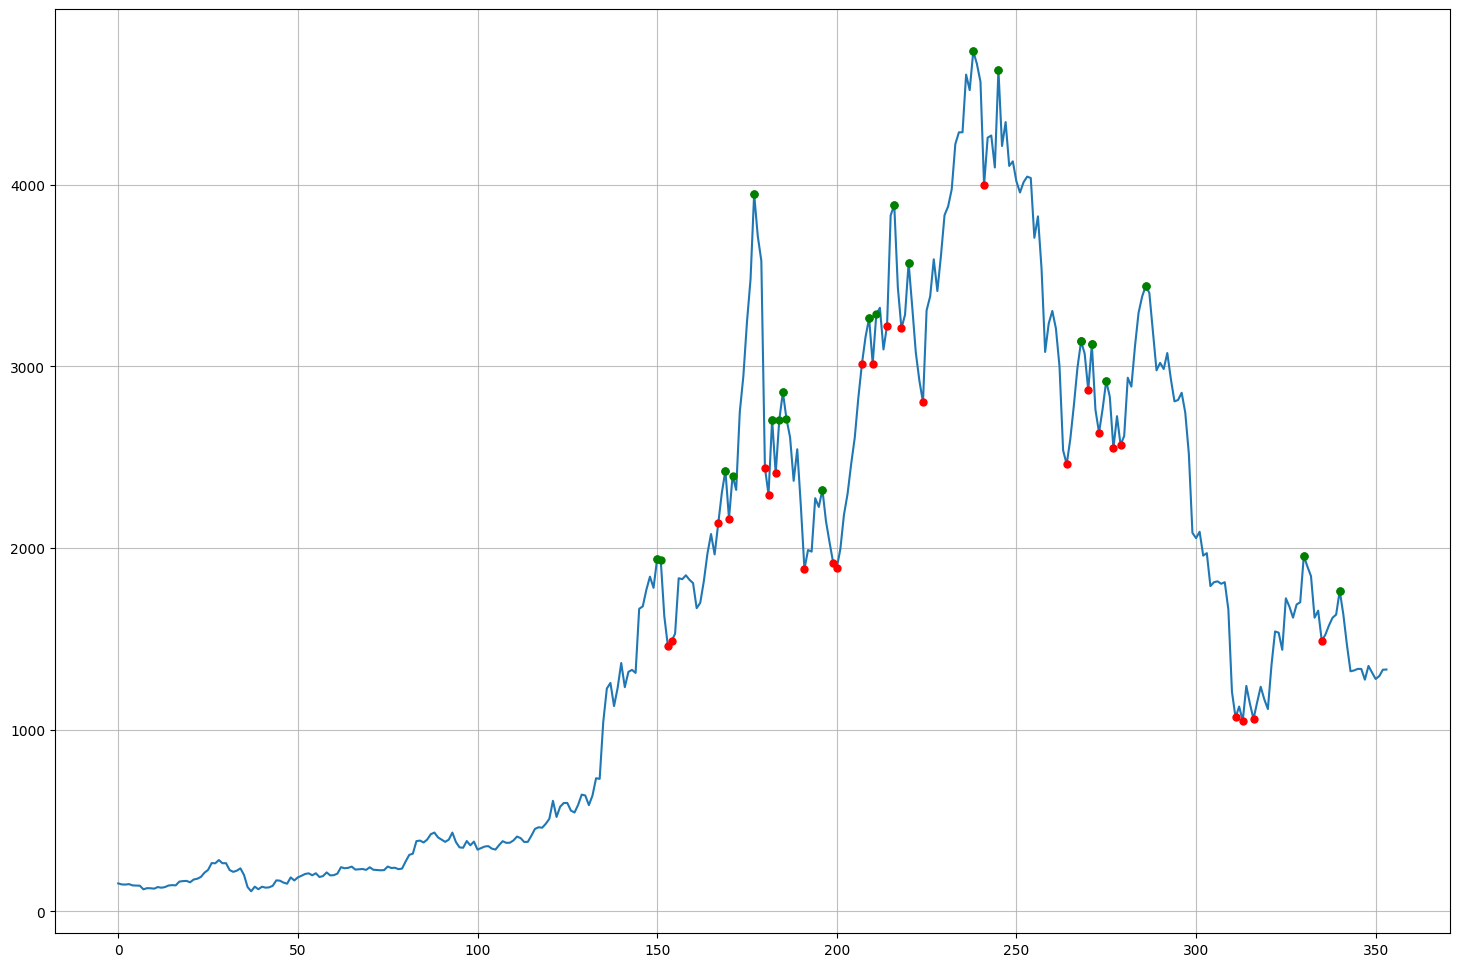

In [48]:
df = sdb.data
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(df.close)
peak_x = peak_regions
peak_y = df.close.values[peak_regions]
ax.plot(peak_x, peak_y, marker='o', markersize=5, linestyle="None", color='green', label="Peaks")

valley_x = valley_regions
valley_y = df.close.values[valley_regions]
ax.plot(valley_x, valley_y, marker='o', markersize=5, linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")

In [43]:
labels = [1 if i in peak_regions else (-1 if i in valley_regions else 0) for i in range(len(df.close.values))]
labels = pd.DataFrame(labels, columns=['labels'])
df = pd.concat([df, labels], axis=1)
# print(labels[labels!=0].dropna())
    

In [44]:
df


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,timestamp,closes_ema,closes_std,closes_z,labels
0,2019-11-27,146.00,157.40,125.03,154.41,4.006420e+05,2019-11-29 23:59:59.999,6.102741e+07,64529,1.493024e+05,2.280285e+07,1574812800000,NaN,NaN,NaN,0
1,2019-11-30,154.40,155.15,145.50,148.59,1.160617e+06,2019-12-02 23:59:59.999,1.741101e+08,133426,4.240349e+05,6.363350e+07,1575072000000,NaN,NaN,NaN,0
2,2019-12-03,148.59,152.22,142.96,148.04,1.621515e+06,2019-12-05 23:59:59.999,2.385031e+08,126763,7.821871e+05,1.150296e+08,1575331200000,NaN,NaN,NaN,0
3,2019-12-06,148.08,156.25,145.66,150.41,8.344414e+05,2019-12-08 23:59:59.999,1.235730e+08,84007,4.218255e+05,6.249326e+07,1575590400000,NaN,NaN,NaN,0
4,2019-12-09,150.41,151.15,142.02,143.35,7.579560e+05,2019-12-11 23:59:59.999,1.112699e+08,77445,3.585358e+05,5.265355e+07,1575849600000,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,2022-10-06,1351.60,1383.29,1302.00,1314.74,1.440381e+07,2022-10-08 23:59:59.999,1.943072e+10,8061324,7.130207e+06,9.622846e+09,1665014400000,1316.763231,40.180660,-0.042599,0
350,2022-10-09,1314.75,1337.93,1265.00,1279.68,1.278600e+07,2022-10-11 23:59:59.999,1.661448e+10,7037719,6.308722e+06,8.198932e+09,1665273600000,1281.997702,38.956360,-0.058439,0
351,2022-10-12,1279.67,1343.36,1176.00,1295.35,2.210043e+07,2022-10-14 23:59:59.999,2.198265e+10,11367477,1.106874e+07,1.099498e+10,1665532800000,1294.515481,27.797746,0.024492,0
352,2022-10-15,1295.34,1338.16,1262.12,1330.62,1.148738e+07,2022-10-17 23:59:59.999,1.496143e+10,6089134,5.780609e+06,7.532021e+09,1665792000000,1328.363468,27.852400,0.077485,0


In [45]:
if DUMP == '.json':
    df.to_json(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}.json"))
elif DUMP == '.csv':
    df.to_csv(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}_features.csv"))    
    labels.to_csv(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}_labels.csv")) 

In [47]:
data_path = os.path.join(NEW_DATA_DIR, f"{PAIR}_{TIMEFRAME}")
print(data_path)       
labels = pd.read_csv(data_path + "_labels.csv")
labels.drop(['Unnamed: 0'], axis=1, inplace=True)
features = pd.read_csv(data_path + "_features.csv")
features.drop(['Unnamed: 0'], axis=1, inplace=True)
print(labels)
print(features)

c:\Users\igor-\.cloned\trailing_orders-1\DEV\datasets\200_ETHUSDT_3d_2018-10-14_2022-10-05\ETHUSDT_3d


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\igor-\\.cloned\\trailing_orders-1\\DEV\\datasets\\200_ETHUSDT_3d_2018-10-14_2022-10-05\\ETHUSDT_3d_labels.csv'

In [72]:
sdb.data = df
features =sdb.data

NameError: name 'features' is not defined

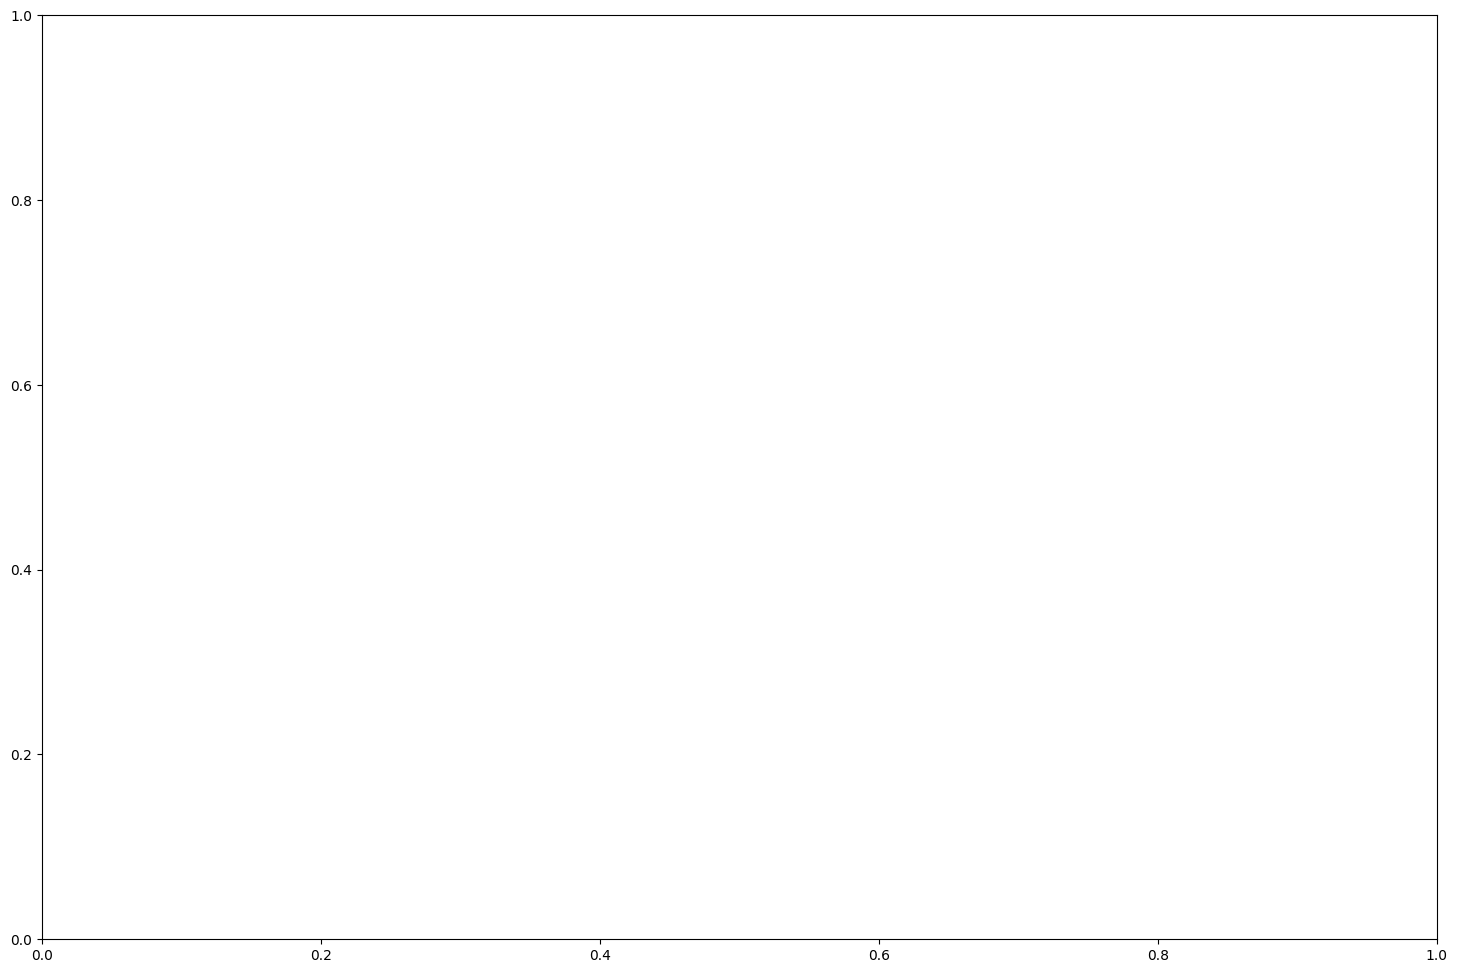

In [50]:
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(features.close)
none = []
for i, l in enumerate(features.labels):
    if l == 1:
        peak_x = peak_regions
        peak_y = features.close.values[peak_regions]
        ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
    elif l == -1:
        valley_x = valley_regions
        valley_y = features.close.values[valley_regions]
        ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
    elif l == 0:
        none.append(i)
none_x = none
none_y = df.close.values[none]
# ax.plot(none_x, none_y, marker='o', linestyle="None", color='yellow', alpha=0.01, label="Valleys")        
# ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
# ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")

In [59]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None, target_transform=None):

        # any additional label treatment
        self.labels = pd.read_csv(data_path + f"_labels{DUMP}")
        self.labels.drop(['Unnamed: 0'], axis=1, inplace=True)
        
        #feature engineering
        self.features = pd.read_csv(data_path + f"_features{DUMP}")
        self.features.drop(['Unnamed: 0'], axis=1, inplace=True)
        self.features.drop(['close_time'], axis=1, inplace=True)
        self.features.drop(['labels'], axis=1, inplace=True)
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

        feature = self.features.iloc[idx, :]
        label = self.labels.iloc[idx]

        if self.transform:
            feature = self.transform(feature)
        if self.target_transform:
            label = self.target_transform(label)
        return feature, label

C:\Users\igor-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
ds = CustomDataset(data_path)


In [27]:
from torch.utils.data import DataLoader

dataloader = DataLoader(ds, batch_size=64, shuffle=True)


In [28]:
ds.features

,open_time,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,1.460000e+00,1,0.000,0.000000e+00
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,0.000000e+00,0,0.000,0.000000e+00
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,1.250300e+00,1,0.000,0.000000e+00
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2.900000e+00,2,0.000,0.000000e+00
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,6.770100e+00,2,0.010,1.450100e+00
...,...,...,...,...,...,...,...,...,...,...
10495,2020-03-17 14:00:00,113.09,114.91,112.51,113.82,35557.698,4.046765e+06,7112,18061.825,2.055813e+06
10496,2020-03-17 14:15:00,113.79,115.50,113.55,115.29,25336.127,2.901673e+06,5690,14325.847,1.641335e+06
10497,2020-03-17 14:30:00,115.28,115.68,114.04,115.40,34254.968,3.937871e+06,5930,17229.602,1.981916e+06
10498,2020-03-17 14:45:00,115.40,115.68,114.77,115.39,19647.917,2.263713e+06,3767,11837.663,1.364054e+06


In [29]:
ds.labels

,labels
0,0
1,0
2,-1
3,1
4,-1
...,...
10495,0
10496,0
10497,0
10498,0


In [30]:
dataloader.dataset.features

,open_time,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,1.460000e+00,1,0.000,0.000000e+00
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,0.000000e+00,0,0.000,0.000000e+00
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,1.250300e+00,1,0.000,0.000000e+00
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2.900000e+00,2,0.000,0.000000e+00
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,6.770100e+00,2,0.010,1.450100e+00
...,...,...,...,...,...,...,...,...,...,...
10495,2020-03-17 14:00:00,113.09,114.91,112.51,113.82,35557.698,4.046765e+06,7112,18061.825,2.055813e+06
10496,2020-03-17 14:15:00,113.79,115.50,113.55,115.29,25336.127,2.901673e+06,5690,14325.847,1.641335e+06
10497,2020-03-17 14:30:00,115.28,115.68,114.04,115.40,34254.968,3.937871e+06,5930,17229.602,1.981916e+06
10498,2020-03-17 14:45:00,115.40,115.68,114.77,115.39,19647.917,2.263713e+06,3767,11837.663,1.364054e+06
